In [1]:
# get emulators
import pickle
import numpy as np
import pandas as pd
emulators = {}
posterior = {}
empirical_data = pd.read_csv('../data/sims_combined-wave004.csv')
empirical_data = empirical_data.loc[empirical_data['rand_seed']==empirical_data['rand_seed'].max()]
def read_pickle(path):
    with open(path,'rb') as stream:
        out = pickle.load(stream)
    return out
em_path = '../models/hetGPy-last-round-[KEY].pkl'
post_path = '../posterior/calibrated-[KEY].csv'
for key in ['diagnoses','death']:
    emulators[key] = read_pickle(f'{em_path.replace("[KEY]",key)}')[key]
    posterior[key] = pd.read_csv(post_path.replace("[KEY]",key))




In [2]:
t = np.unique(emulators['diagnoses'].X0[:,-1])
rng = np.random.default_rng(1)
def sample_from_posterior_predictive(em,X):
    Xrep = np.vstack([X]*len(t))
    Xp = np.hstack([Xrep,t.reshape(-1,1)])
    p = em.predict(Xp)
    mu = p['mean']
    sd = (p['sd2'] + p['nugs'])**0.5
    return pd.DataFrame({'t':t,'pred':rng.normal(loc=mu,scale=sd)})

diagnoses_sims = []
deaths_sims = []
n = 1000
for i in range(n):
    out1 = sample_from_posterior_predictive(
        emulators['diagnoses'],
        posterior['diagnoses'].sample(random_state=i,n=1).values.reshape(-1)
    )
    out2 = sample_from_posterior_predictive(
        emulators['death'],
        posterior['death'].sample(random_state=i,n=1).values.reshape(-1)
    )
    diagnoses_sims.append(out1)
    deaths_sims.append(out2)
diagnoses_sims = pd.concat(diagnoses_sims).rename({'pred':'diagnoses'},axis='columns')
deaths_sims = pd.concat(deaths_sims).rename({'pred':'death'},axis='columns')

/Users/davidogara/code/Covasim-Calibration/covasim-calibration/.covasim_calibration/lib/python3.10/site-packages/hetgpy/hetGP.py:1429: UserWarning: Numerical errors caused some negative predictive variances to be thresholded to zero. Consider using ginv via rebuild.homGP
  warnings.warn("Numerical errors caused some negative predictive variances to be thresholded to zero. Consider using ginv via rebuild.homGP")


In [3]:
from scipy.stats import qmc
tmin, tmax = empirical_data['t'].min(), empirical_data['t'].max()
def scale_t(t):
    return qmc.scale(t,l_bounds=tmin,u_bounds=tmax)
def aggregate_sims(data):
    col = [c for c in ['diagnoses','death'] if c in data.columns][0]
    p = [0.025,0.5,0.975]
    agg = data.groupby('t')[col].describe(percentiles=p).reset_index()[['t','2.5%','50%','97.5%']]
    agg.columns = ['t',f"{col}_lower",f"{col}_median",f"{col}_upper"]
    agg['t'] = scale_t(agg['t'].values.reshape(-1,1))
    return agg
diagnoses_agg = aggregate_sims(diagnoses_sims)
deaths_agg = aggregate_sims(deaths_sims)


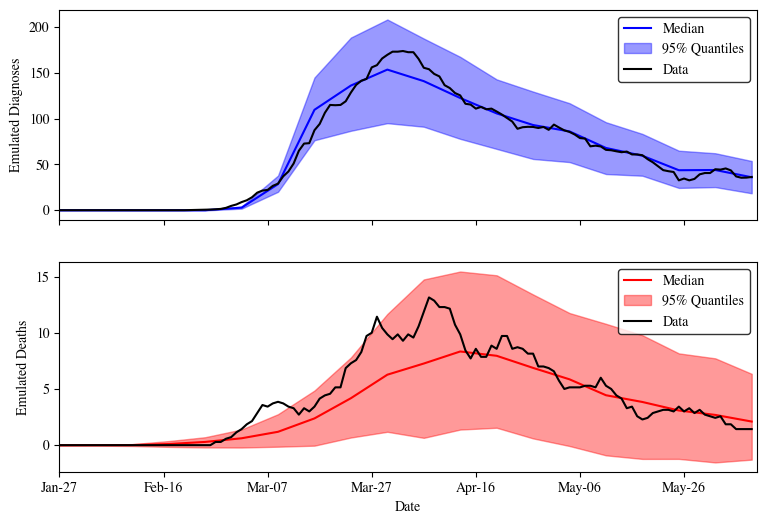

In [10]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import datetime as dt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Times']})
rc('text', usetex=False)
rc('grid', linestyle="--", color='black')
fig, ax = plt.subplots(nrows=2,figsize=(9,6),sharex=True)
n_days = len(empirical_data)
start_day = pd.to_datetime('2020-01-27')
def format_ax(ax):
    ''' Format the axes nicely '''
    @ticker.FuncFormatter
    def date_formatter(x, pos):
        return (start_day + dt.timedelta(days=x)).strftime('%b-%d')
    ax.xaxis.set_major_formatter(date_formatter)
    ax.set_xlim([0, n_days])
# diagnoses
ax[0].plot(diagnoses_agg['t'],diagnoses_agg['diagnoses_median'],color='blue',label='Median')
ax[0].fill_between(
    diagnoses_agg['t'],
    diagnoses_agg['diagnoses_lower'],diagnoses_agg['diagnoses_upper'],
    alpha=0.4,color='blue',label='95% Quantiles'
)
ax[0].plot(empirical_data['t'],empirical_data['diagnoses_data'],color='black',label='Data')
ax[0].set_ylabel('Emulated Diagnoses')
# death
ax[1].plot(deaths_agg['t'],deaths_agg['death_median'],color='red',label='Median')
ax[1].fill_between(
    deaths_agg['t'],
    deaths_agg['death_lower'],deaths_agg['death_upper'],
    alpha=0.4,color='red',label='95% Quantiles'
)
ax[1].plot(empirical_data['t'],empirical_data['death_data'],color='black',label='Data')
ax[1].set_ylabel('Emulated Deaths')
ax[1].set_xlabel('Date')
format_ax(ax[1])
lkws = dict(edgecolor='black',loc='upper right')
ax[0].legend(**lkws); ax[1].legend(**lkws)
fig.savefig('../response-figs/Supp-Calibrated-Emulator.pdf')

In [ ]:
# emulator correlation statistics
seq = np.arange(tmin,tmax+7,7)
corr_diag = np.corrcoef(
    diagnoses_agg['diagnoses_median'].values,
    empirical_data['diagnoses_data'].values[seq]
)
corr_death = np.corrcoef(
    deaths_agg['death_median'].values,
    empirical_data['death_data'].values[seq]
)
corr_diag[0,1], corr_death[0,1]


(0.9896000409746345, 0.9289596081936145)

In [21]:
# emulator rmse statistics
rmse_diagnoses = ((diagnoses_agg['diagnoses_median'].values -
 empirical_data['diagnoses_data'].values[seq])**2).mean()**0.5
rmse_deaths =  ((deaths_agg['death_median'].values -
 empirical_data['death_data'].values[seq])**2).mean()**0.5
rmse_diagnoses, rmse_deaths 


(7.78085878171662, 1.7494950621122771)